# Topic Modelling Notebook

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from bertopic import BERTopic
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sklearn.metrics import davies_bouldin_score


c:\Users\Richelle\Documents\Data Science\DSA4213_Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd

# Load the file
path_train = r"..\embeddings_output\general_train_broad_embeddings.npz" # path to npz file
data_train = np.load(path_train, allow_pickle=True)
path_test = r"..\embeddings_output\general_test_broad_embeddings.npz" # path to npz file
data_test = np.load(path_test, allow_pickle=True)

print({k: data_train[k].shape for k in data_train.files})

embeddings_train = pd.DataFrame(data_train["embeddings"])
embeddings_train.columns = [f"emb_{i}" for i in range(embeddings_train.shape[1])]  # rename nicely
embeddings_train["text"] = data_train["texts"]
embeddings_train["label"] = data_train["labels"]

embeddings_test = pd.DataFrame(data_test["embeddings"])
embeddings_test.columns = [f"emb_{i}" for i in range(embeddings_test.shape[1])]  # rename nicely
embeddings_test["text"] = data_test["texts"]
embeddings_test["label"] = data_test["labels"]

print(embeddings_train.shape)
print(embeddings_train.head())

print(embeddings_test.shape)
print(embeddings_test.head())


{'embeddings': (11200, 384), 'texts': (11200,), 'labels': (11200,)}
(11200, 386)
      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.065954  0.129986 -0.027290  0.022978 -0.060881  0.020859 -0.097683   
1 -0.002379  0.061337  0.029013  0.004404 -0.013388 -0.011926 -0.017382   
2 -0.020936  0.029716  0.003486  0.019713 -0.003231  0.021080 -0.052675   
3 -0.100052  0.001816 -0.010475 -0.046205  0.034331 -0.054387  0.107253   
4 -0.011559 -0.028765  0.057984  0.075947  0.047227 -0.019874  0.011059   

      emb_7     emb_8     emb_9  ...   emb_376   emb_377   emb_378   emb_379  \
0  0.023718 -0.103246 -0.029989  ... -0.049650 -0.002975  0.014075 -0.105049   
1  0.044410 -0.059244 -0.088396  ... -0.055617  0.069392  0.007593  0.106782   
2  0.079946 -0.039729  0.032833  ... -0.047487  0.079180 -0.075348  0.085130   
3  0.026428  0.038723 -0.113006  ... -0.057479  0.006368 -0.001778  0.022304   
4  0.044840 -0.066399 -0.011631  ... -0.051420 -0.055166  0.038959  

In [3]:
texts = data_train["texts"]
labels = data_train["labels"]
emb_matrix = data_train["embeddings"]  # shape: (11200, 384)

train_df = pd.DataFrame({
    "text": texts,
    "label": labels,
    "embeddings": [vec.tolist() for vec in emb_matrix]
})

texts = data_test["texts"]
labels = data_test["labels"]
emb_matrix = data_test["embeddings"]  # shape: (11200, 384)

test_df = pd.DataFrame({
    "text": texts,
    "label": labels,
    "embeddings": [vec.tolist() for vec in emb_matrix]
})
print(train_df.shape, test_df.shape)

(11200, 3) (7430, 3)


In [4]:
train_df

text label  \
0      i was wondering if anyone out there could enli...     3   
1      a fair number of brave souls who upgraded thei...     1   
2      well folks my mac plus finally gave up the gho...     1   
3      robert jc kyanko wrote do you have weiteks add...     1   
4      from article by tom a baker my understanding i...     2   
...                                                  ...   ...   
11195  dn from david nye dn a neurology dn consultati...     2   
11196  i have a very old mac 512k and a mac plus both...     1   
11197  i just installed a dx266 cpu in a clone mother...     1   
11198  in article edward bolson writes wouldnt this r...     1   
11199  stolen from pasadena between 430 and 630 pm on...     3   

                                              embeddings  
0      [-0.06595448404550552, 0.1299862265586853, -0....  
1      [-0.0023794814478605986, 0.06133740022778511, ...  
2      [-0.020935537293553352, 0.029716189950704575, ...  
3      [-0.10005185008049011, 0.0018155976431444287, ...  
4      [-0.011558858677744865, -0.0287648793309927, 0...  
...                                                  ...  
11195  [-0.08230961114168167, -0.004875315818935633, ...  
11196  [0.03424368426203728, -0.012400401756167412, 0...  
11197  [-0.02444905787706375, -0.01412092987447977, 0...  
11198  [0.04212794080376625, -0.06897043436765671, -0...  
11199  [-0.07660923898220062, 0.06032640486955643, 0....  

[11200 rows x 3 columns]

# Topic Modeling 

## Init topic model

In [ ]:
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
SEED = 42
from bertopic import BERTopic

# custom words to ignore
CUSTOM_STOPWORDS = []

# Pass your own preprocessor to remove them
def custom_preprocessor(text):
    text = text.lower()
    for w in CUSTOM_STOPWORDS:
        text = text.replace(w, " ")  # simple remove
    return text

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)


vectorizer_model = CountVectorizer(
    stop_words="english",     # remove stopwords for topic representation
    preprocessor=custom_preprocessor,
    ngram_range=(1, 1),       # unigrams + bigrams (tweak if needed)
    min_df=1,                 # drop very rare terms
    max_df=1.0
)

topic_model = BERTopic(
    embedding_model=None,             
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    low_memory=True,
    calculate_probabilities=True,
    verbose=True,
    nr_topics= 20,                   # keep all topics (no reduction)
)

print("BERTopic initialized with fixed random seed:", SEED)

BERTopic initialized with fixed random seed: 42


In [6]:
docs = embeddings_train["text"].tolist()
embeddings_train = embeddings_train[[f"emb_{i}" for i in range(embeddings_train.shape[1]-2)]].to_numpy()

topics, probs = topic_model.fit_transform(docs, embeddings_train)
print("Unique topics (excl. -1 outliers):", sorted(t for t in set(topics) if t != -1))

2025-10-26 15:23:36,298 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-26 15:24:07,705 - BERTopic - Dimensionality - Completed ✓
2025-10-26 15:24:07,706 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-26 15:24:15,830 - BERTopic - Cluster - Completed ✓
2025-10-26 15:24:15,830 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-10-26 15:24:17,618 - BERTopic - Representation - Completed ✓
2025-10-26 15:24:17,622 - BERTopic - Topic reduction - Reducing number of topics
2025-10-26 15:24:17,657 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-26 15:24:19,361 - BERTopic - Representation - Completed ✓
2025-10-26 15:24:19,361 - BERTopic - Topic reduction - Reduced number of topics from 141 to 20


Unique topics (excl. -1 outliers): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [7]:
train_df["Topic"] = topics
train_df["Topic_Probability"] = [max(p) if p is not None else None for p in probs]
train_df

text label  \
0      i was wondering if anyone out there could enli...     3   
1      a fair number of brave souls who upgraded thei...     1   
2      well folks my mac plus finally gave up the gho...     1   
3      robert jc kyanko wrote do you have weiteks add...     1   
4      from article by tom a baker my understanding i...     2   
...                                                  ...   ...   
11195  dn from david nye dn a neurology dn consultati...     2   
11196  i have a very old mac 512k and a mac plus both...     1   
11197  i just installed a dx266 cpu in a clone mother...     1   
11198  in article edward bolson writes wouldnt this r...     1   
11199  stolen from pasadena between 430 and 630 pm on...     3   

                                              embeddings  Topic  \
0      [-0.06595448404550552, 0.1299862265586853, -0....      5   
1      [-0.0023794814478605986, 0.06133740022778511, ...      1   
2      [-0.020935537293553352, 0.029716189950704575, ...      1   
3      [-0.10005185008049011, 0.0018155976431444287, ...      3   
4      [-0.011558858677744865, -0.0287648793309927, 0...     -1   
...                                                  ...    ...   
11195  [-0.08230961114168167, -0.004875315818935633, ...      0   
11196  [0.03424368426203728, -0.012400401756167412, 0...     -1   
11197  [-0.02444905787706375, -0.01412092987447977, 0...     -1   
11198  [0.04212794080376625, -0.06897043436765671, -0...     12   
11199  [-0.07660923898220062, 0.06032640486955643, 0....     -1   

       Topic_Probability  
0               0.451721  
1               0.186417  
2               0.623818  
3               0.021859  
4               0.128161  
...                  ...  
11195           0.336263  
11196           0.291437  
11197           0.280818  
11198           1.000000  
11199           0.378423  

[11200 rows x 5 columns]

In [8]:
topic_info = topic_model.get_topic_info()
topic_info.head()

Topic  Count                           Name  \
0     -1   3660     -1_writes_article_like_use   
1      0   1455   0_people_writes_article_dont   
2      1   1222      1_drive_card_windows_scsi   
3      2   1123       2_team_game_games_season   
4      3    646  3_key_encryption_chip_clipper   

                                      Representation  \
0  [writes, article, like, use, just, dont, know,...   
1  [people, writes, article, dont, think, gun, kn...   
2  [drive, card, windows, scsi, disk, drives, tha...   
3  [team, game, games, season, hockey, play, year...   
4  [key, encryption, chip, clipper, keys, use, pr...   

                                 Representative_Docs  
0  [i have come across what i consider to be an e...  
1  [in article thomas parsli writes so like what ...  
2  [wayne smith wrote who said isa was necessary ...  
3  [tampa bay 1 1 02 philadelphia 3 2 16 first pe...  
4  [archivename netprivacypart1 lastmodified 1993...

In [9]:
topic_model.visualize_barchart()

In [10]:
topic_model.visualize_topics()

## Use Gemini to label topics 

In [ ]:
import os
from dotenv import load_dotenv
import sys
from pathlib import Path

# Load .env from one directory up
load_dotenv(dotenv_path="../.env")

# Access your key
api_key = os.getenv("GEMINI_API_KEY")
print("GEMINI_API_KEY:", api_key[:6], "..." if api_key else "MISSING")

GEMINI_API_KEY: AIzaSy ...


In [ ]:
import sys
from pathlib import Path
# get path to project root (one level above notebooks/)
root = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path.cwd().parent
sys.path.append(str(root / "src"))
from gemini_utils import label_topics_from_df
import time

# --- CONFIG ---
NUM_BATCHES = 2
WAIT_TIME_SEC = 60  # 1 minute between batches

# Split into ~10 equal chunks
batches = np.array_split(topic_info, NUM_BATCHES)

labels_list = []

for i, batch in enumerate(batches, start=1):
    print(f"🔹 Processing batch {i}/{NUM_BATCHES} with {len(batch)} topics...")

    try:
        # Call your API function
        labels_chunk = label_topics_from_df(batch, api_key=api_key)
        labels_list.append(labels_chunk)
        print(f"Batch {i} done. Waiting {WAIT_TIME_SEC}s before next batch...")

    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue

    # Wait before next API call, unless this was the last batch
    if i < NUM_BATCHES:
        time.sleep(WAIT_TIME_SEC)

# Merge all labeled results
labels_df = pd.concat(labels_list, ignore_index=True)

# Merge back with original topic_info
final_df = topic_info.merge(labels_df, on="Topic", how="left")

display(final_df.head())
print("All batches completed.")

GEMINI_API_KEY: AIzaSy ...
🔹 Processing batch 1/2 with 10 topics...
tuned_topic_name='Politics & Society' short_explanation='This cluster encompasses discussions and articles, particularly those related to governmental communications and public discourse, as evidenced by references to the White House press secretary.'
tuned_topic_name='Computers & Technology' short_explanation='This cluster focuses on computer hardware and software, including discussions about disk drives, expansion cards, the Windows operating system, and SCSI interfaces.'
tuned_topic_name='Sports' short_explanation='This cluster is focused on professional sports, specifically hockey, discussing teams, games, seasons, and standings. It covers competitive aspects and results within the sport.'
tuned_topic_name='Computers & Technology' short_explanation="This cluster focuses on digital security, encryption methods, and privacy concerns in technology, particularly referencing topics like the 'clipper chip' and 'netprivac

Topic  Count                           Name  \
0     -1   3660     -1_writes_article_like_use   
1      0   1455   0_people_writes_article_dont   
2      1   1222      1_drive_card_windows_scsi   
3      2   1123       2_team_game_games_season   
4      3    646  3_key_encryption_chip_clipper   

                                      Representation  \
0  [writes, article, like, use, just, dont, know,...   
1  [people, writes, article, dont, think, gun, kn...   
2  [drive, card, windows, scsi, disk, drives, tha...   
3  [team, game, games, season, hockey, play, year...   
4  [key, encryption, chip, clipper, keys, use, pr...   

                                 Representative_Docs        tuned_topic_name  \
0  [i have come across what i consider to be an e...                     NaN   
1  [in article thomas parsli writes so like what ...      Politics & Society   
2  [wayne smith wrote who said isa was necessary ...  Computers & Technology   
3  [tampa bay 1 1 02 philadelphia 3 2 16 first pe...                  Sports   
4  [archivename netprivacypart1 lastmodified 1993...  Computers & Technology   

                                   short_explanation  
0                                                NaN  
1  This cluster encompasses discussions and artic...  
2  This cluster focuses on computer hardware and ...  
3  This cluster is focused on professional sports...  
4  This cluster focuses on digital security, encr...

🎉 All batches completed.


In [13]:
# join finetuned back to main dataframe
# plot number of each topic in each department
train_df = train_df.merge(labels_df[["Topic", "tuned_topic_name", "short_explanation"]], on="Topic", how="left")
train_df

text label  \
0      i was wondering if anyone out there could enli...     3   
1      a fair number of brave souls who upgraded thei...     1   
2      well folks my mac plus finally gave up the gho...     1   
3      robert jc kyanko wrote do you have weiteks add...     1   
4      from article by tom a baker my understanding i...     2   
...                                                  ...   ...   
11195  dn from david nye dn a neurology dn consultati...     2   
11196  i have a very old mac 512k and a mac plus both...     1   
11197  i just installed a dx266 cpu in a clone mother...     1   
11198  in article edward bolson writes wouldnt this r...     1   
11199  stolen from pasadena between 430 and 630 pm on...     3   

                                              embeddings  Topic  \
0      [-0.06595448404550552, 0.1299862265586853, -0....      5   
1      [-0.0023794814478605986, 0.06133740022778511, ...      1   
2      [-0.020935537293553352, 0.029716189950704575, ...      1   
3      [-0.10005185008049011, 0.0018155976431444287, ...      3   
4      [-0.011558858677744865, -0.0287648793309927, 0...     -1   
...                                                  ...    ...   
11195  [-0.08230961114168167, -0.004875315818935633, ...      0   
11196  [0.03424368426203728, -0.012400401756167412, 0...     -1   
11197  [-0.02444905787706375, -0.01412092987447977, 0...     -1   
11198  [0.04212794080376625, -0.06897043436765671, -0...     12   
11199  [-0.07660923898220062, 0.06032640486955643, 0....     -1   

       Topic_Probability                 tuned_topic_name  \
0               0.451721  Recreation (Vehicles & Hobbies)   
1               0.186417           Computers & Technology   
2               0.623818           Computers & Technology   
3               0.021859           Computers & Technology   
4               0.128161                              NaN   
...                  ...                              ...   
11195           0.336263               Politics & Society   
11196           0.291437                              NaN   
11197           0.280818                              NaN   
11198           1.000000           Computers & Technology   
11199           0.378423                              NaN   

                                       short_explanation  
0      This cluster primarily discusses vehicles like...  
1      This cluster focuses on computer hardware and ...  
2      This cluster focuses on computer hardware and ...  
3      This cluster focuses on digital security, encr...  
4                                                    NaN  
...                                                  ...  
11195  This cluster encompasses discussions and artic...  
11196                                                NaN  
11197                                                NaN  
11198  This cluster focuses on computational geometry...  
11199                                                NaN  

[11200 rows x 7 columns]

In [28]:
CATEGORY_NAME_MAP = {
    1: "Computers & Technology",
    2: "Science & Engineering",
    3: "Recreation (Vehicles & Hobbies)",
    4: "Sports",
    5: "Religion",
    6: "Politics & Society",
    7: "Marketplace / Miscellaneous"
}
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}
train_df["predicted_topic_id"] = train_df["tuned_topic_name"].map(CATEGORY_NAME_TO_INT)
train_df["predicted_topic_id"] = train_df["predicted_topic_id"].fillna(-1).astype(int)
train_df


text label  \
0      i was wondering if anyone out there could enli...     3   
1      a fair number of brave souls who upgraded thei...     1   
2      well folks my mac plus finally gave up the gho...     1   
3      robert jc kyanko wrote do you have weiteks add...     1   
4      from article by tom a baker my understanding i...     2   
...                                                  ...   ...   
11195  dn from david nye dn a neurology dn consultati...     2   
11196  i have a very old mac 512k and a mac plus both...     1   
11197  i just installed a dx266 cpu in a clone mother...     1   
11198  in article edward bolson writes wouldnt this r...     1   
11199  stolen from pasadena between 430 and 630 pm on...     3   

                                              embeddings  Topic  \
0      [-0.06595448404550552, 0.1299862265586853, -0....      5   
1      [-0.0023794814478605986, 0.06133740022778511, ...      1   
2      [-0.020935537293553352, 0.029716189950704575, ...      1   
3      [-0.10005185008049011, 0.0018155976431444287, ...      3   
4      [-0.011558858677744865, -0.0287648793309927, 0...     -1   
...                                                  ...    ...   
11195  [-0.08230961114168167, -0.004875315818935633, ...      0   
11196  [0.03424368426203728, -0.012400401756167412, 0...     -1   
11197  [-0.02444905787706375, -0.01412092987447977, 0...     -1   
11198  [0.04212794080376625, -0.06897043436765671, -0...     12   
11199  [-0.07660923898220062, 0.06032640486955643, 0....     -1   

       Topic_Probability                 tuned_topic_name  \
0               0.451721  Recreation (Vehicles & Hobbies)   
1               0.186417           Computers & Technology   
2               0.623818           Computers & Technology   
3               0.021859           Computers & Technology   
4               0.128161                              NaN   
...                  ...                              ...   
11195           0.336263               Politics & Society   
11196           0.291437                              NaN   
11197           0.280818                              NaN   
11198           1.000000           Computers & Technology   
11199           0.378423                              NaN   

                                       short_explanation  predicted_topic_id  
0      This cluster primarily discusses vehicles like...                   3  
1      This cluster focuses on computer hardware and ...                   1  
2      This cluster focuses on computer hardware and ...                   1  
3      This cluster focuses on digital security, encr...                   1  
4                                                    NaN                  -1  
...                                                  ...                 ...  
11195  This cluster encompasses discussions and artic...                   6  
11196                                                NaN                  -1  
11197                                                NaN                  -1  
11198  This cluster focuses on computational geometry...                   1  
11199                                                NaN                  -1  

[11200 rows x 8 columns]

<Axes: title={'center': 'Predicted Topic ID Distribution in Training Set'}, xlabel='Predicted Topic ID', ylabel='Count'>

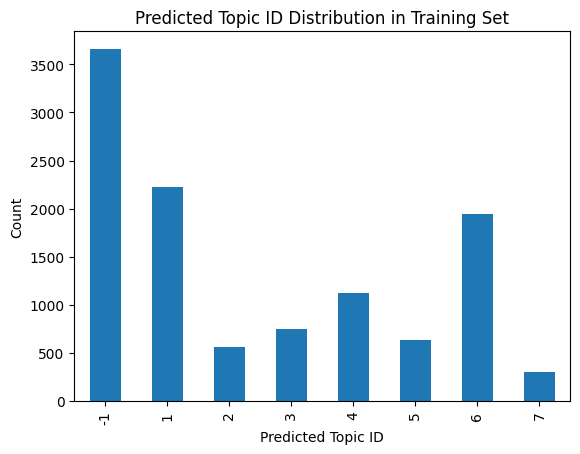

In [23]:
train_df.predicted_topic_id.value_counts().sort_index().plot(kind='bar', title='Predicted Topic ID Distribution in Training Set', xlabel='Predicted Topic ID', ylabel='Count')

Original samples: 11200
After removing outliers (Topic=-1): 7540
Outliers removed: 3660 (32.68%)

After removing unmapped predictions: 7540

[Saved] results\category_alignment\default_metrics.json


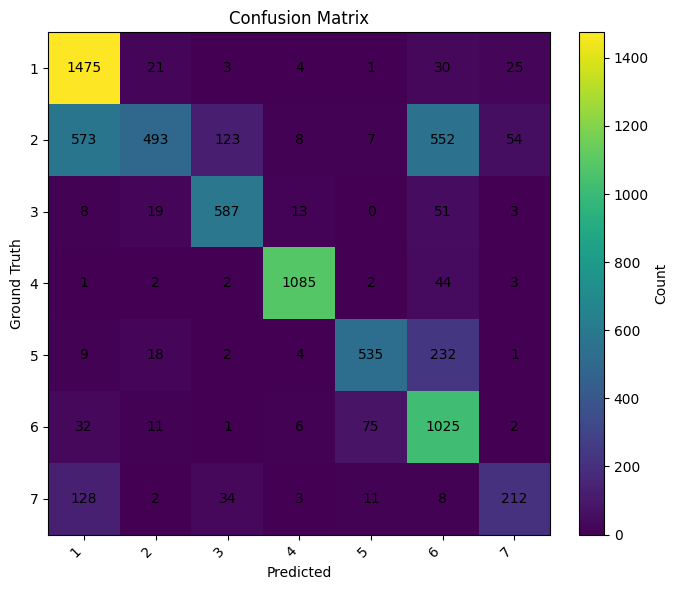

{'macro_f1': 0.7128847295122187,
 'weighted_f1': 0.6923533760636502,
 'per_class_f1': [0.7793923381770145,
  0.414983164983165,
  0.8192602930914166,
  0.9593280282935456,
  0.7472067039106145,
  0.6625727213962508,
  0.6074498567335244],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'confusion_matrix': [[1475, 21, 3, 4, 1, 30, 25],
  [573, 493, 123, 8, 7, 552, 54],
  [8, 19, 587, 13, 0, 51, 3],
  [1, 2, 2, 1085, 2, 44, 3],
  [9, 18, 2, 4, 535, 232, 1],
  [32, 11, 1, 6, 75, 1025, 2],
  [128, 2, 34, 3, 11, 8, 212]]}

In [33]:
from Evaluations.category_alignment import compute_category_alignment

# Filter out outliers (Topic = -1) before evaluation
train_df_filtered = train_df[train_df["Topic"] != -1].copy()

print(f"Original samples: {len(train_df)}")
print(f"After removing outliers (Topic=-1): {len(train_df_filtered)}")
print(f"Outliers removed: {len(train_df) - len(train_df_filtered)} ({100*(len(train_df) - len(train_df_filtered))/len(train_df):.2f}%)")
print()

# Also filter out any predictions that are -1 (unmapped categories)
train_df_filtered = train_df_filtered[train_df_filtered["predicted_topic_id"] != -1].copy()
print(f"After removing unmapped predictions: {len(train_df_filtered)}")
print()

# Compute metrics on filtered data
compute_category_alignment(
    train_df_filtered["predicted_topic_id"].astype('int64'), 
    train_df_filtered["label"].astype('int64'), 
    plot_confusion=True
)

# Testing on test set

In [14]:
# load topic model and test embeddings 
docs = embeddings_test["text"].tolist()
embeddings_test = embeddings_test[[f"emb_{i}" for i in range(embeddings_test.shape[1]-2)]].to_numpy()

topics_test, probs_test = topic_model.transform(docs, embeddings_test)

2025-10-26 15:26:51,464 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-10-26 15:27:08,688 - BERTopic - Dimensionality - Completed ✓
2025-10-26 15:27:08,690 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-10-26 15:27:08,987 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-10-26 15:27:15,377 - BERTopic - Probabilities - Completed ✓
2025-10-26 15:27:15,377 - BERTopic - Cluster - Completed ✓


In [34]:
test_df["Topic"] = topics_test
test_df["Topic_Probability"] = [max(p) if p is not None else None for p in probs_test]
test_df

text label  \
0     i am a little confused on all of the models of...     3   
1     im not familiar at all with the format of thes...     1   
2     turin turambar me department of utter misery w...     5   
3     in article ilyess b bdira writes they were att...     6   
4     in article norman r paterson writes in article...     5   
...                                                 ...   ...   
7425  henry spencer writes henry if i read you corre...     2   
7426  in article paul nevai writes about them on act...     1   
7427  i sent a version of this post out a while ago ...     4   
7428  i have this kit which includes the following 1...     7   
7429  in article d andrew kille writes fine but one ...     5   

                                             embeddings  Topic  \
0     [-0.09357887506484985, -0.009670850820839405, ...     -1   
1     [-0.07837384194135666, 0.00878608226776123, -0...     -1   
2     [-0.0190329197794199, 0.06360288709402084, 0.0...     -1   
3     [0.023197058588266373, -0.017748378217220306, ...      6   
4     [-0.03030456230044365, -0.03915141895413399, -...      0   
...                                                 ...    ...   
7425  [-0.03778066486120224, 0.005880645476281643, 0...      7   
7426  [-0.026070421561598778, -0.08614310622215271, ...     -1   
7427  [0.0901314839720726, 0.061336617916822433, 0.0...      2   
7428  [-0.0983097106218338, 0.09242044389247894, -0....     -1   
7429  [-0.03095187619328499, -0.0006003307062201202,...      4   

      Topic_Probability  
0              0.324905  
1              0.333262  
2              0.833078  
3              0.648390  
4              0.193885  
...                 ...  
7425           0.999782  
7426           0.220034  
7427           0.999999  
7428           0.144411  
7429           0.901189  

[7430 rows x 5 columns]

In [35]:
test_df = test_df.merge(labels_df[["Topic", "tuned_topic_name", "short_explanation"]], on="Topic", how="left")
test_df


text label  \
0     i am a little confused on all of the models of...     3   
1     im not familiar at all with the format of thes...     1   
2     turin turambar me department of utter misery w...     5   
3     in article ilyess b bdira writes they were att...     6   
4     in article norman r paterson writes in article...     5   
...                                                 ...   ...   
7425  henry spencer writes henry if i read you corre...     2   
7426  in article paul nevai writes about them on act...     1   
7427  i sent a version of this post out a while ago ...     4   
7428  i have this kit which includes the following 1...     7   
7429  in article d andrew kille writes fine but one ...     5   

                                             embeddings  Topic  \
0     [-0.09357887506484985, -0.009670850820839405, ...     -1   
1     [-0.07837384194135666, 0.00878608226776123, -0...     -1   
2     [-0.0190329197794199, 0.06360288709402084, 0.0...     -1   
3     [0.023197058588266373, -0.017748378217220306, ...      6   
4     [-0.03030456230044365, -0.03915141895413399, -...      0   
...                                                 ...    ...   
7425  [-0.03778066486120224, 0.005880645476281643, 0...      7   
7426  [-0.026070421561598778, -0.08614310622215271, ...     -1   
7427  [0.0901314839720726, 0.061336617916822433, 0.0...      2   
7428  [-0.0983097106218338, 0.09242044389247894, -0....     -1   
7429  [-0.03095187619328499, -0.0006003307062201202,...      4   

      Topic_Probability       tuned_topic_name  \
0              0.324905                    NaN   
1              0.333262                    NaN   
2              0.833078                    NaN   
3              0.648390     Politics & Society   
4              0.193885     Politics & Society   
...                 ...                    ...   
7425           0.999782  Science & Engineering   
7426           0.220034                    NaN   
7427           0.999999                 Sports   
7428           0.144411                    NaN   
7429           0.901189               Religion   

                                      short_explanation  
0                                                   NaN  
1                                                   NaN  
2                                                   NaN  
3     This cluster focuses on geopolitical discussio...  
4     This cluster encompasses discussions and artic...  
...                                                 ...  
7425  This cluster focuses on space exploration, sat...  
7426                                                NaN  
7427  This cluster is focused on professional sports...  
7428                                                NaN  
7429  This cluster focuses on topics related to reli...  

[7430 rows x 7 columns]

In [36]:
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}
test_df["predicted_topic_id"] = test_df["tuned_topic_name"].map(CATEGORY_NAME_TO_INT)
test_df["predicted_topic_id"] = test_df["predicted_topic_id"].fillna(-1).astype(int)
test_df

text label  \
0     i am a little confused on all of the models of...     3   
1     im not familiar at all with the format of thes...     1   
2     turin turambar me department of utter misery w...     5   
3     in article ilyess b bdira writes they were att...     6   
4     in article norman r paterson writes in article...     5   
...                                                 ...   ...   
7425  henry spencer writes henry if i read you corre...     2   
7426  in article paul nevai writes about them on act...     1   
7427  i sent a version of this post out a while ago ...     4   
7428  i have this kit which includes the following 1...     7   
7429  in article d andrew kille writes fine but one ...     5   

                                             embeddings  Topic  \
0     [-0.09357887506484985, -0.009670850820839405, ...     -1   
1     [-0.07837384194135666, 0.00878608226776123, -0...     -1   
2     [-0.0190329197794199, 0.06360288709402084, 0.0...     -1   
3     [0.023197058588266373, -0.017748378217220306, ...      6   
4     [-0.03030456230044365, -0.03915141895413399, -...      0   
...                                                 ...    ...   
7425  [-0.03778066486120224, 0.005880645476281643, 0...      7   
7426  [-0.026070421561598778, -0.08614310622215271, ...     -1   
7427  [0.0901314839720726, 0.061336617916822433, 0.0...      2   
7428  [-0.0983097106218338, 0.09242044389247894, -0....     -1   
7429  [-0.03095187619328499, -0.0006003307062201202,...      4   

      Topic_Probability       tuned_topic_name  \
0              0.324905                    NaN   
1              0.333262                    NaN   
2              0.833078                    NaN   
3              0.648390     Politics & Society   
4              0.193885     Politics & Society   
...                 ...                    ...   
7425           0.999782  Science & Engineering   
7426           0.220034                    NaN   
7427           0.999999                 Sports   
7428           0.144411                    NaN   
7429           0.901189               Religion   

                                      short_explanation  predicted_topic_id  
0                                                   NaN                  -1  
1                                                   NaN                  -1  
2                                                   NaN                  -1  
3     This cluster focuses on geopolitical discussio...                   6  
4     This cluster encompasses discussions and artic...                   6  
...                                                 ...                 ...  
7425  This cluster focuses on space exploration, sat...                   2  
7426                                                NaN                  -1  
7427  This cluster is focused on professional sports...                   4  
7428                                                NaN                  -1  
7429  This cluster focuses on topics related to reli...                   5  

[7430 rows x 8 columns]

Original samples: 7430
After removing outliers (Topic=-1): 4309
Outliers removed: 3121 (42.01%)

After removing unmapped predictions: 4309

[Saved] results\category_alignment\default_metrics.json


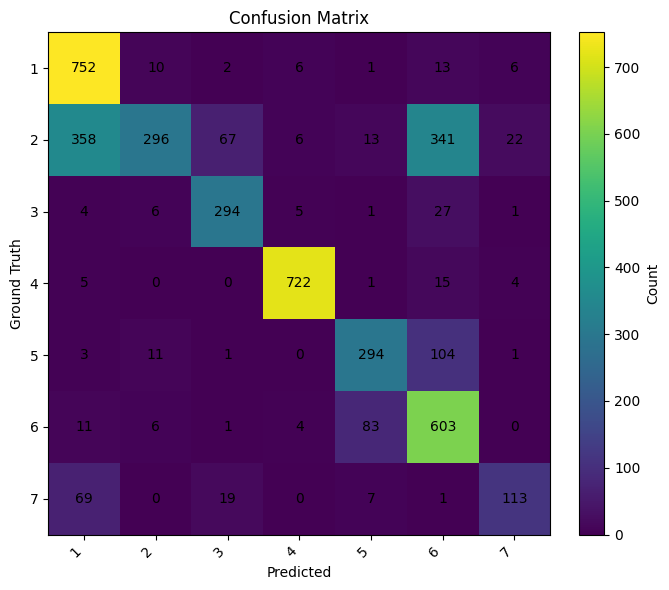

{'macro_f1': 0.7106732782002839,
 'weighted_f1': 0.6856849553835517,
 'per_class_f1': [0.7550200803212851,
  0.4134078212290503,
  0.814404432132964,
  0.9691275167785235,
  0.7223587223587223,
  0.6655629139072847,
  0.6348314606741573],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'confusion_matrix': [[752, 10, 2, 6, 1, 13, 6],
  [358, 296, 67, 6, 13, 341, 22],
  [4, 6, 294, 5, 1, 27, 1],
  [5, 0, 0, 722, 1, 15, 4],
  [3, 11, 1, 0, 294, 104, 1],
  [11, 6, 1, 4, 83, 603, 0],
  [69, 0, 19, 0, 7, 1, 113]]}

In [37]:
from Evaluations.category_alignment import compute_category_alignment

# Filter out outliers (Topic = -1) before evaluation
test_df_filtered = test_df[test_df["Topic"] != -1].copy()

print(f"Original samples: {len(test_df)}")
print(f"After removing outliers (Topic=-1): {len(test_df_filtered)}")
print(f"Outliers removed: {len(test_df) - len(test_df_filtered)} ({100*(len(test_df) - len(test_df_filtered))/len(test_df):.2f}%)")
print()

# Also filter out any predictions that are -1 (unmapped categories)
test_df_filtered = test_df_filtered[test_df_filtered["predicted_topic_id"] != -1].copy()
print(f"After removing unmapped predictions: {len(test_df_filtered)}")
print()

# Compute metrics on filtered data
compute_category_alignment(
    test_df_filtered["predicted_topic_id"].astype('int64'), 
    test_df_filtered["label"].astype('int64'), 
    plot_confusion=True
)